# **Assignment 4 - Time-Series Analysis**
## Author: Jake Brulato
## Tuesday 5:30 - 8:15 : Kornelia

In [208]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [209]:
# Load the CSV file into a DataFrame
file_path = 'gas_prod.csv'
gas_production_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
gas_production_data.head()

,Month,Gas_prod
0,1,384.261096
1,2,380.107310
2,3,392.967363
3,4,402.114680
4,5,393.519639


# **1. Generate a plot of the monthly gas production with proper labels.  Paste a screenshot in the Word document. (5)  Once you have read the csv data, before moving to any other step, use the following code to convert the “Month” column to a proper date column of equal monthly intervals.**
 
- Assume the sequence starts in January 2004 and ends in December 2023 (12 months x 20 years) 
- start_date = '2004-01' 
 
- Generate a date range starting from the start_date, with a frequency of one month, and length equal to the dataset 
- df['Date'] = pd.date_range(start=start_date, periods=len(df), freq='M') 

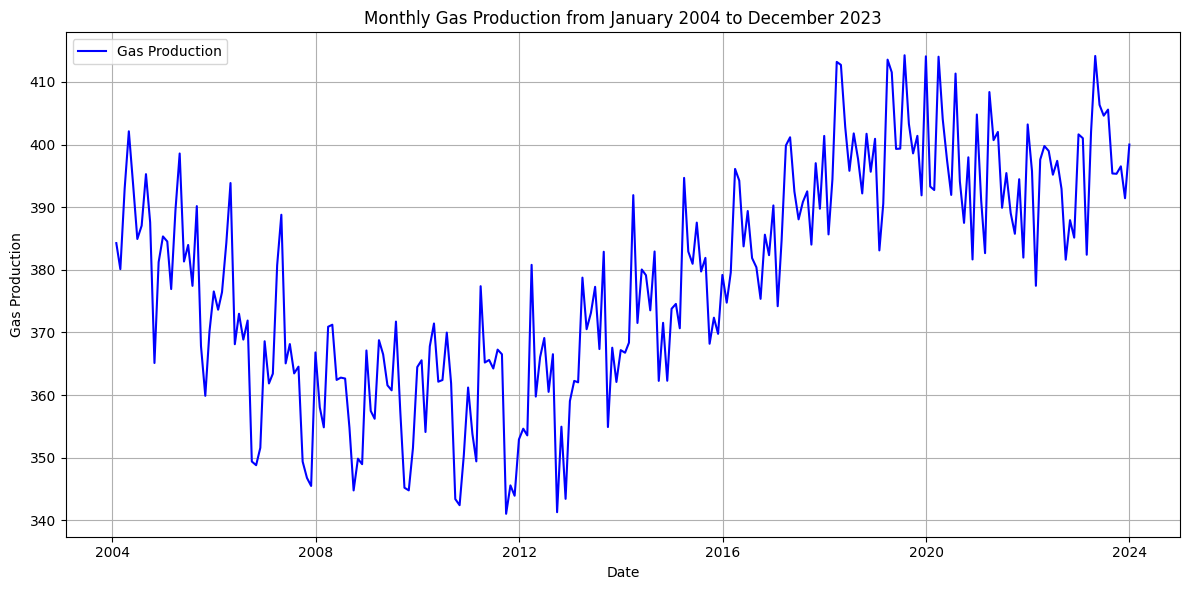

In [210]:
# Define the start date for the date range
start_date = '2004-01'

# Create a date range from the start date with monthly frequency and length equal to the dataset
gas_production_data['Date'] = pd.date_range(start=start_date, periods=len(gas_production_data), freq='M')

# Convert data to time series
gas_ts = pd.Series(gas_production_data.Gas_prod.values, index=gas_production_data.Date, name='Gas_prod')

# Plotting the monthly gas production
plt.figure(figsize=(12, 6))
plt.plot(gas_production_data['Date'], gas_production_data['Gas_prod'], label='Gas Production', color='blue')
plt.title('Monthly Gas Production from January 2004 to December 2023')
plt.xlabel('Date')
plt.ylabel('Gas Production')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# **2. Split the data into training and validation sets.  Use the last three years of data for validation set and the remaining as the training set. Run the following forecasting models. (5)**

In [211]:
# Data partition for the time series data
# Keep the last three years data as the validation dataset
nValid = 36
nTrain = len(gas_ts) - nValid
train_ts = gas_ts[:nTrain]
valid_ts = gas_ts[nTrain:]

## (a)  Linear trend

In [212]:
# Model 1: A linear trend time series model
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
ts_df = tsatools.add_trend(gas_ts,trend='ct')  # "ct" adds both constant and trend
ts_df['Month']=ts_df.index.month

# display updated ts_df
ts_df

,Gas_prod,const,trend,Month
Date,,,,
2004-01-31,384.261096,1.0,1.0,1
2004-02-29,380.107310,1.0,2.0,2
2004-03-31,392.967363,1.0,3.0,3
2004-04-30,402.114680,1.0,4.0,4
2004-05-31,393.519639,1.0,5.0,5
...,...,...,...,...
2023-08-31,395.379147,1.0,236.0,8
2023-09-30,395.330980,1.0,237.0,9
2023-10-31,396.520100,1.0,238.0,10


In [213]:
# partition data frame into training and validation to run regression
nValid = 36
nTrain = len(gas_ts) - nValid
train_df = ts_df[:nTrain]
valid_df = ts_df[nTrain:]

In [214]:
# fit a linear regression model
linear_lm = sm.ols(formula='Gas_prod ~ trend',data=train_df).fit()

linear_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gas_prod   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     70.15
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           9.15e-15
Time:                        15:37:47   Log-Likelihood:                -845.41
No. Observations:                 204   AIC:                             1695.
Df Residuals:                     202   BIC:                             1701.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    360.1673      2.155    167.108      0.000     355.918     364.417
trend          0.1527      0.018      8.376      0.000       0.117       0.189
==============================================================================
Omnibus:                        2.009   Durbin-Watson:                   0.545
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.957
Skew:                           0.169   Prob(JB):                        0.376
Kurtosis:                       2.660   Cond. No.                         237.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [215]:
# Evaluate Model1 performance
# ! pip install dmba
# Comment the above install code after dmba library has been installed
from dmba import regressionSummary
predict_lm = linear_lm.predict(valid_df)
regressionSummary(valid_ts,predict_lm)


Regression statistics

                      Mean Error (ME) : 1.1510
       Root Mean Squared Error (RMSE) : 8.2360
            Mean Absolute Error (MAE) : 6.7058
          Mean Percentage Error (MPE) : 0.2482
Mean Absolute Percentage Error (MAPE) : 1.6962


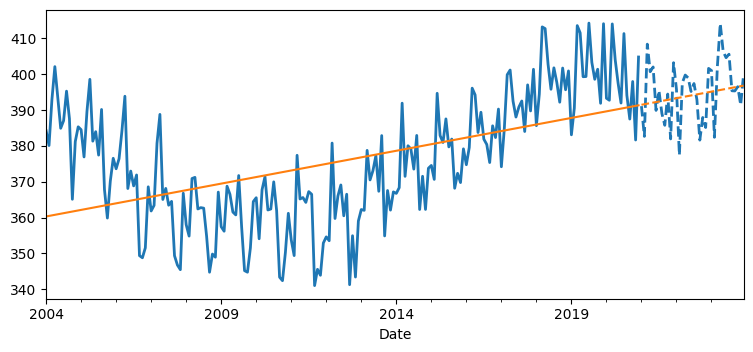

In [216]:
# Blue line for the original time series
# Orange line for the forecasted time series
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3.75))
train_df.plot(y='Gas_prod',ax=ax,color='C0',linewidth=2)
valid_df.plot(y='Gas_prod',ax=ax,color='C0',linewidth=2, linestyle='dashed')
linear_lm.predict(train_df).plot(color='C1')
linear_lm.predict(valid_df).plot(color='C1',linestyle='dashed')
ax.get_legend().remove()
plt.show()

## (b)  Seasonality

In [217]:
# Model 2: A polynomial trend time series model
import numpy as np
season_lm = sm.ols(formula='Gas_prod ~ C(Month)',
data=train_df).fit()
season_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gas_prod   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     3.781
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           6.41e-05
Time:                        15:37:47   Log-Likelihood:                -855.82
No. Observations:                 204   AIC:                             1736.
Df Residuals:                     192   BIC:                             1775.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        371.0753      4.015     92.431      0.000     363.157     378.994
C(Month)[T.2]     -0.0141      5.678     -0.002      0.998     -11.212      11.184
C(Month)[T.3]     18.0605      5.678      3.181      0.002       6.862      29.259
C(Month)[T.4]     15.1649      5.678      2.671      0.008       3.967      26.363
C(Month)[T.5]      7.4953      5.678      1.320      0.188      -3.703      18.694
C(Month)[T.6]      7.6185      5.678      1.342      0.181      -3.580      18.817
C(Month)[T.7]      8.3115      5.678      1.464      0.145      -2.887      19.510
C(Month)[T.8]      8.0284      5.678      1.414      0.159      -3.170      19.227
C(Month)[T.9]     -6.7881      5.678     -1.196      0.233     -17.987       4.410
C(Month)[T.10]    -3.2364      5.678     -0.570      0.569     -14.435       7.962
C(Month)[T.11]    -5.0732      5.678     -0.894      0.373     -16.272       6.125
C(Month)[T.12]     7.3717      5.678      1.298      0.196      -3.827      18.570
==============================================================================
Omnibus:                       35.363   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.109
Skew:                           0.343   Prob(JB):                      0.00235
Kurtosis:                       2.024   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
# Evaluate Model2 performance
predict_season_lm = season_lm.predict(valid_df)
regressionSummary(valid_ts,predict_season_lm)


Regression statistics

                      Mean Error (ME) : 19.4764
       Root Mean Squared Error (RMSE) : 20.5194
            Mean Absolute Error (MAE) : 19.4764
          Mean Percentage Error (MPE) : 4.9112
Mean Absolute Percentage Error (MAPE) : 4.9112


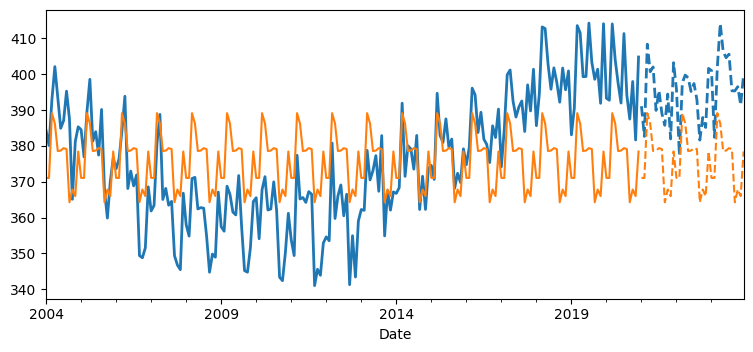

In [219]:
# Blue line for the original time series
# Orange line for the forecasted time series
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3.75))
train_df.plot(y='Gas_prod',ax=ax,color='C0',linewidth=2)
valid_df.plot(y='Gas_prod',ax=ax,color='C0',linewidth=2, linestyle='dashed')
season_lm.predict(train_df).plot(color='C1')
season_lm.predict(valid_df).plot(color='C1',linestyle='dashed')
ax.get_legend().remove()
plt.show()

## (c)  Quadratic trend and seasonality (remember that quadratic trend includes a linear trend term)

In [220]:
# Model 5: A model with polynomial trend and seasonality
modelfomula = 'Gas_prod ~ trend + np.square(trend) + C(Month)'
gas_lm_trendseason = sm.ols(formula=modelfomula, data=train_df).fit()
gas_lm_trendseason.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gas_prod   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     68.90
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           1.35e-64
Time:                        15:37:47   Log-Likelihood:                -698.03
No. Observations:                 204   AIC:                             1424.
Df Residuals:                     190   BIC:                             1471.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          380.6398      2.395    158.952      0.000     375.916     385.363
C(Month)[T.2]       -0.1348      2.633     -0.051      0.959      -5.329       5.060
C(Month)[T.3]       17.8120      2.634      6.764      0.000      12.617      23.007
C(Month)[T.4]       14.7816      2.634      5.613      0.000       9.587      19.977
C(Month)[T.5]        6.9702      2.634      2.647      0.009       1.775      12.165
C(Month)[T.6]        6.9445      2.634      2.637      0.009       1.749      12.140
C(Month)[T.7]        7.4816      2.634      2.840      0.005       2.286      12.677
C(Month)[T.8]        7.0355      2.634      2.671      0.008       1.839      12.232
C(Month)[T.9]       -7.9509      2.634     -3.018      0.003     -13.148      -2.754
C(Month)[T.10]      -4.5763      2.635     -1.737      0.084      -9.773       0.621
C(Month)[T.11]      -6.5971      2.635     -2.504      0.013     -11.795      -1.399
C(Month)[T.12]       5.6568      2.635      2.146      0.033       0.458      10.855
trend               -0.5650      0.037    -15.401      0.000      -0.637      -0.493
np.square(trend)     0.0035      0.000     20.291      0.000       0.003       0.004
==============================================================================
Omnibus:                        1.515   Durbin-Watson:                   1.060
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.321
Skew:                          -0.196   Prob(JB):                        0.517
Kurtosis:                       3.050   Cond. No.                     2.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [221]:
# Evaluate Model5 performance
predict_lm_trendseason = gas_lm_trendseason.predict(valid_df)
regressionSummary(valid_ts,predict_lm_trendseason)


Regression statistics

                      Mean Error (ME) : -38.0559
       Root Mean Squared Error (RMSE) : 39.1968
            Mean Absolute Error (MAE) : 38.0559
          Mean Percentage Error (MPE) : -9.6359
Mean Absolute Percentage Error (MAPE) : 9.6359


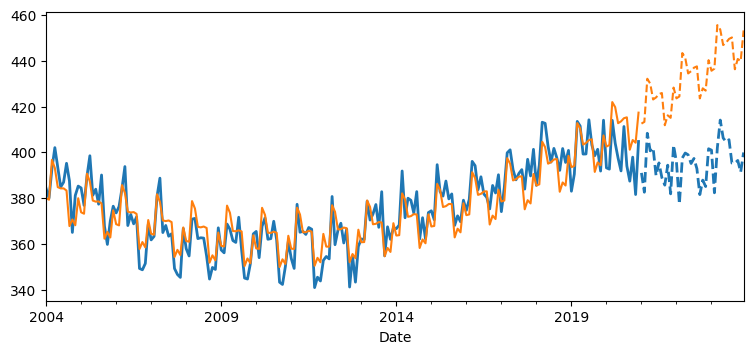

In [222]:
# Blue line for the original time series
# Orange line for the forecasted time series
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3.75))
train_df.plot(y='Gas_prod',ax=ax,color='C0',linewidth=2)
valid_df.plot(y='Gas_prod',ax=ax,color='C0',linewidth=2, linestyle='dashed')
gas_lm_trendseason.predict(train_df).plot(color='C1')
gas_lm_trendseason.predict(valid_df).plot(color='C1',linestyle='dashed')
ax.get_legend().remove()
plt.show()

# **3. In the Word document, write a short paragraph for each model about the model performance using any three metrics.  Which model performs best?  Justify your answer. (15)**

### - Based on the "Regression Statistics" the best performing model would be the linear trend, having the lowest RMSE and MAPE values signifing that it had the closest prediction accuracy compared to the othe models. It's ME and MPE are also close to 0 indicating that there is little to no bias when it does its predictions.


### - The linear model has statistics of Mean Error (ME) : 1.1510, Root Mean Squared Error (RMSE) : 8.2360, Mean Absolute Error (MAE) : 6.7058, Mean Percentage Error (MPE) : 0.2482, and Mean Absolute Percentage Error (MAPE) : 1.6962. This is by far the lowest of all the statistical models thus far having little bias and closest prediction accuracy.

### - The seasonality has statistics of Mean Error (ME) : 19.4764, Root Mean Squared Error (RMSE) : 20.5194, Mean Absolute Error (MAE) : 19.4764, Mean Percentage Error (MPE) : 4.9112, and Mean Absolute Percentage Error (MAPE) : 4.9112. This has the second lowest RMSE and MAE meaning it has less prediction compared to linear, but higher ME, MPE, and MAPE indicating more bias and less predictive capability.

### - The Quadratic Trend and Seasonality has statistics of Mean Error (ME) : -38.0559, Root Mean Squared Error (RMSE) : 39.1968, Mean Absolute Error (MAE) : 38.0559, Mean Percentage Error (MPE) : -9.6359, Mean Absolute Percentage Error (MAPE) : 9.6359. Has the lowest ME and MPE in the negative likely because of the log in the model, but has the highest of all the other values making me less inclined to use it.

# **4. Take the gas_prod for any 12 consecutive months from the dataset.  In the Word document, show in a table the original gas_prod values, a simple moving average forecast with 6-month rolling period, and an exponential smoothing forecast with alpha=0.2. (5)**

In [223]:
# Using pandas to compute the Simple Moving Average (SMA) with a window of 12 months
gas_production_data['SMA_6'] = gas_production_data['Gas_prod'].rolling(window=6).mean()

# Using pandas to compute Exponential Smoothing (ES); here we use a common smoothing factor alpha = 0.2
gas_production_data['ES_0.2'] = gas_production_data['Gas_prod'].ewm(alpha=0.2, adjust=False).mean()

# Show the dataset with the new SMA and ES columns
gas_production_data[['Gas_prod', 'SMA_6', 'ES_0.2']].tail()  # Displaying 15 rows to see some of the moving averages starting to form

,Gas_prod,SMA_6,ES_0.2
235,395.379147,404.673264,400.340140
236,395.330980,403.563036,399.338308
237,396.520100,400.625618,398.774667
238,391.428054,398.141716,397.305344
239,400.000000,397.373326,397.844275


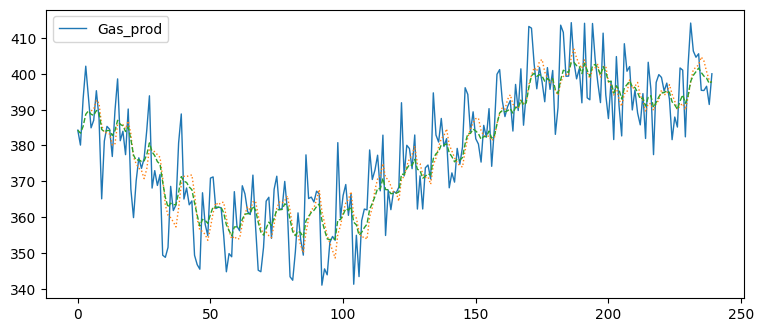

In [224]:
# Visualize the moving average forecast
x = gas_production_data["SMA_6"].dropna()
y = gas_production_data["ES_0.2"]

# Blue line for x
# Orange line for y
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3.75))
gas_production_data.plot(y='Gas_prod', ax=ax,color='C0', linewidth=1)
x.plot(y='SMA_6',ax=ax,color='C1',linewidth=1, linestyle='dotted')
y.plot(y='ES_0.2',ax=ax,color='C2',linewidth=1, linestyle='dashed')
plt.show()

# **5. Build and run a forecasting model using SARIMA.  Explain the process of choosing the values for p, d, and q for the SARIMA model (Use ACF and PACF plots; Do not use the automated search algorithm to pick the best SARIMA parameters). Write a paragraph commenting on the SARIMA results, including the model performance and the AR and MA parameters.  (15)**

In [225]:
# Dickey-Fuller Test to verify whether a time-series is stationary
# Null hypothesis: Series is non-stationary
# p-vlaue: non-significance indicating non-stationary
# Test Statistic > Critical Value: Reject null hypothesis and conclude Series is stationary

from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(gas_ts.values[1:],autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#lags used', 'Number of observations Used'])

for key , value in dftest[4].items(): dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.664424
p-value                          0.855751
#lags used                      15.000000
Number of observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


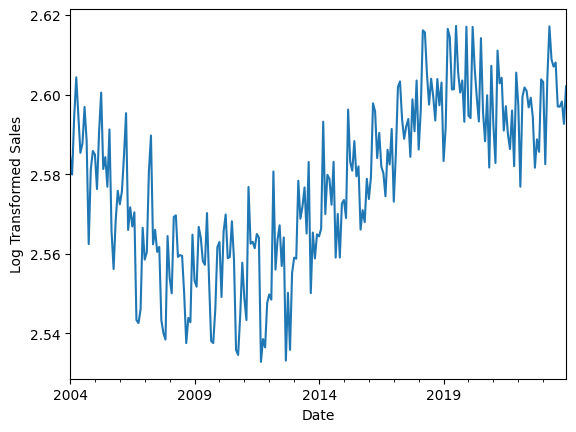

In [226]:
# Log transformation to achieve constant variance
import numpy as np
gas_ts_log = np.log10(gas_ts)
ax = gas_ts_log.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Log Transformed Sales')
plt.show()

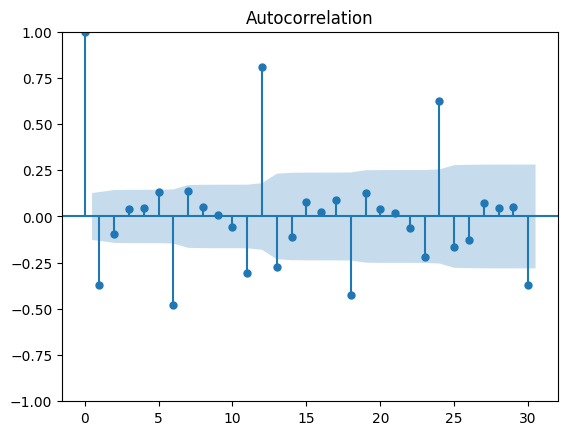

In [227]:
# Plot ACF to check potential seasonality
# ACF: autocorrelation factor
import statsmodels.tsa.api as smt
gas_ts_log_diff = gas_ts_log.diff(periods= 1)
gas_ts_log_diff.dropna(inplace=True)
smt.graphics.plot_acf(gas_ts_log_diff, lags=30, alpha= 0.05)
plt.show()

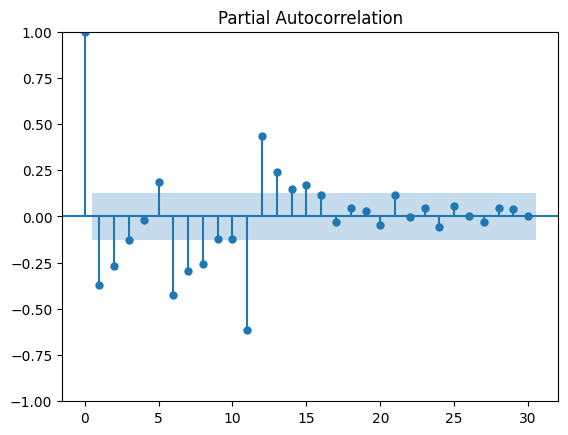

In [228]:
# Partial ACF plot to show significant lags
smt.graphics.plot_pacf(gas_ts_log_diff, lags=30, alpha= 0.05)
plt.show()

In [229]:
# Data partition for the time series data
# Keep the last three years data as the validation dataset
nValid = 36
nTrain = len(gas_ts_log) - nValid
train_ts = gas_ts_log[:nTrain]
valid_ts = gas_ts_log[nTrain:]

In [234]:
# Test a SARIMA model
import statsmodels.api as sm
temp_model = sm.tsa.statespace.SARIMAX(train_ts,
                                       order=(0,1,1),
                                       seasonal_order=(1,0,0,12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)
results = temp_model.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.34186D+00    |proj g|=  6.31424D+01

At iterate    5    f= -3.65117D+00    |proj g|=  1.40362D-01

At iterate   10    f= -3.65125D+00    |proj g|=  2.47398D+00

At iterate   15    f= -3.65816D+00    |proj g|=  2.51188D+01

At iterate   20    f= -3.67625D+00    |proj g|=  1.13402D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     47      1     0     0   1.134D-01  -3.676D+00
  F =  -3.6762452443995324     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


### - The AIC and BIC values are negative, indicating a good fit with the data.
### - All tested values in the function are statistically significant.
### - Log Likelihood is 749.954.
### - The Skew of .5 is so it is right in the center for being symetrical.
### - Heteroskedasticity (H) is 0.85, which suggests that there is no significant heteroscedasticity in the model, which is a good result in terms of the assumptions behind regression analysis.

In [231]:
# forecast with the fitted model
pred = results.get_forecast(steps=36,alpha=0.05)

# Get the forecasted values
forecasted_values = pred.predicted_mean

# Get the confidence intervals for the forecasted values
confidence_intervals = pred.conf_int()

# Print the forecasted values
print("Forecasted values:")
print(forecasted_values)

# Print the confidence intervals
print("\n95% confidence intervals:")
print(confidence_intervals)

Forecasted values:
2021-01-31    2.587974
2021-02-28    2.587445
2021-03-31    2.607143
2021-04-30    2.598061
2021-05-31    2.591941
2021-06-30    2.586704
2021-07-31    2.604708
2021-08-31    2.588763
2021-09-30    2.582427
2021-10-31    2.592378
2021-11-30    2.576759
2021-12-31    2.598733
2022-01-31    2.582180
2022-02-28    2.581725
2022-03-31    2.598651
2022-04-30    2.590847
2022-05-31    2.585589
2022-06-30    2.581089
2022-07-31    2.596559
2022-08-31    2.582858
2022-09-30    2.577413
2022-10-31    2.585964
2022-11-30    2.572543
2022-12-31    2.591424
2023-01-31    2.577202
2023-02-28    2.576811
2023-03-31    2.591354
2023-04-30    2.584649
2023-05-31    2.580131
2023-06-30    2.576264
2023-07-31    2.589556
2023-08-31    2.577784
2023-09-30    2.573106
2023-10-31    2.580453
2023-11-30    2.568921
2023-12-31    2.585144
Freq: ME, Name: predicted_mean, dtype: float64

95% confidence intervals:
            lower Gas_prod  upper Gas_prod
2021-01-31        2.576653        2.

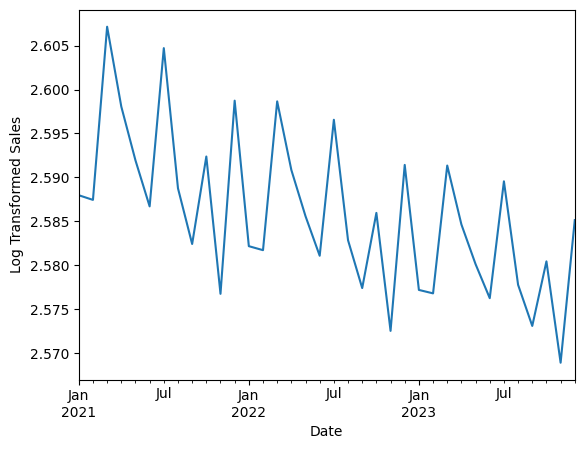

In [232]:
ax = pred.predicted_mean.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Log Transformed Sales')
plt.show()

In [233]:

from dmba import regressionSummary
regressionSummary(np.power(10,valid_ts),
                  np.power(10,pred.predicted_mean))


Regression statistics

                      Mean Error (ME) : 9.8548
       Root Mean Squared Error (RMSE) : 13.3390
            Mean Absolute Error (MAE) : 10.7085
          Mean Percentage Error (MPE) : 2.4658
Mean Absolute Percentage Error (MAPE) : 2.6864


# **6. Compare the best model chosen from step 3 with the SARIMA model.  Which model is better for forecasting between the two?  Justify your answer. (5)**

 - The ME is higher in the SARIMA model, indicating a greater average error per forecast.
 - The RMSE is almost double in the SAMIRA model compared to the linear model, suggesting that the SARIMA model has larger prediction errors overall, especially when
 penalizing larger errors.
- The MAE is also higher for the SARIMA model, meaning the average error magnitude is larger.
- The MPE is larger in the SARIMA model, indicating a tendency to overpredict as opposed to the relatively neutral linear model.
- The MAPE for the SARIMA model is higher than the linear model, which means the prediction errors represent a larger proportion of the actual values.
- Based on these metrics, the linear model still appears to outperform the SAMIRA model, as it has lower values across all the key metrics, suggesting it provides more accurate and less biased forecasts.

### - Overall the Linear model still outperforms the SARIMA, likely because of the lack of complexity in our data being a two column without massive fluctuations and more strennuous predictors.